# Homework
## Preparing the data

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [117]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [118]:
feature_cols = [
	'engine_displacement',
	'horsepower',
	'vehicle_weight',
	'model_year',
	'fuel_efficiency_mpg'
]
df = df.loc[:, feature_cols]

## EDA

In [119]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


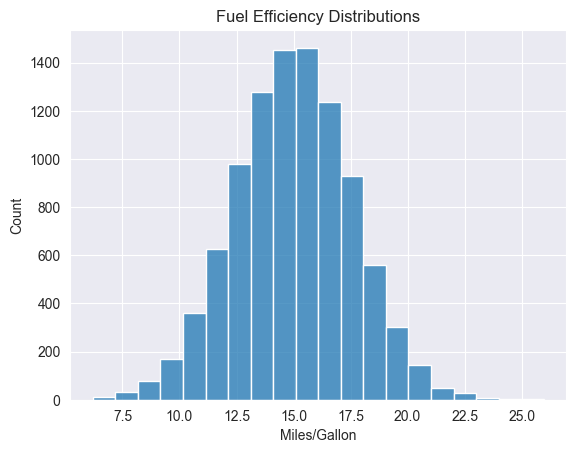

In [120]:
sns.histplot(df, x="fuel_efficiency_mpg", bins=20)
plt.title("Fuel Efficiency Distributions")
plt.xlabel("Miles/Gallon")
plt.show()

> The `fuel_efficiency_mpg` does not show significant skew

### Question 1
There's one column with missing values. What is it?

In [121]:
print("Columns with missing values:", list(df.columns[df.isna().sum() > 0]))

Columns with missing values: ['horsepower']


### Q2. Records count
What's the median (50% percentile) for variable 'horsepower'?

In [122]:
print("Median of the 'horsepower' variable: ", df.horsepower.median())

Median of the 'horsepower' variable:  149.0


## Splitting the dataset

In [123]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [124]:
y_train_orig = df_train.fuel_efficiency_mpg.values
y_val_orig = df_val.fuel_efficiency_mpg.values
y_test_orig = df_test.fuel_efficiency_mpg.values

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [125]:
assert df_val.shape == df_test.shape

### Question 4
#### Model 1: Replace missing values with 0

In [126]:
def train_linear_regression(X, y):
	ones = np.ones(X.shape[0])
	X = np.column_stack([ones, X])

	XTX = X.T.dot(X)
	XTX_inv = np.linalg.inv(XTX)
	w = XTX_inv.dot(X.T).dot(y)

	return w[0], w[1:]

In [127]:
def rmse(y, y_pred):
	error = y_pred - y
	mse = (error ** 2).mean()
	return np.sqrt(mse)

In [128]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_train = df_train[base].fillna(0)
w_0, w = train_linear_regression(X_train, y_train)

In [129]:
X_val = df_val[base].fillna(0)
y_pred = w_0 + X_val.dot(w)

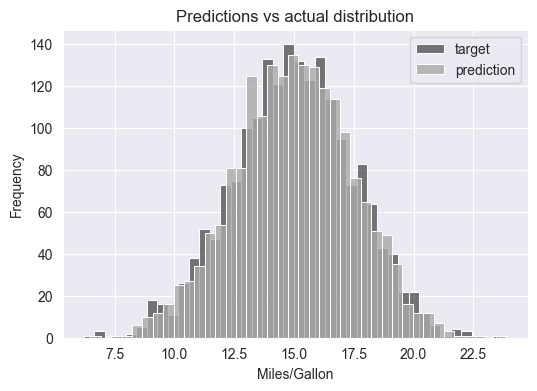

In [130]:
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Miles/Gallon')
plt.title('Predictions vs actual distribution')

plt.show()

In [131]:
print(f"{rmse(y_val, y_pred):.3}")

0.523


#### Model 2: Replace missing values with feature's mean value